#                               Seam carving - proširivanje slike

##                                                 Prva strategija

<Figure size 640x480 with 0 Axes>

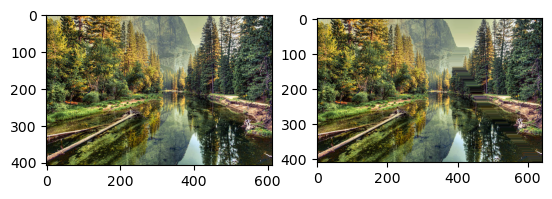

In [38]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage


def seam_carving_enlarge(image, target_width):
    current_width = image.size[0]
    current_height = image.size[1]
    image = np.array(image).astype(int)
    
    while current_width < target_width:
        sx = ndimage.sobel(image, axis = 0, mode='constant')
        sy = ndimage.sobel(image, axis = 1, mode='constant')
        sobel = np.absolute(sx) + np.absolute(sy)
        energy = sobel.sum(axis = 2)
        
        M = np.zeros([current_height, current_width])
        # prvi red je energija piksela iz prvog reda
        M[0] = energy[0]
        for i in range(1, current_height):
            M[i, 0] = energy[i, 0] + min(M[i - 1, 0], M[i - 1, 1])
            M[i, current_width - 1] = energy[i, current_width - 1] + min(M[i - 1, current_width - 1], M[i - 1, current_width - 2])
            for j in range(1, current_width - 1):
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
        seam = np.zeros([current_height]).astype(int)
        m = 0
        for j in range(1, current_width):
            if M[current_height - 1, 0] > M[current_height - 1, j]:
                m = j
            seam[current_height - 1] = m
        
        for i in reversed(range(1, current_height)):
            j = seam[i]
            if j == 0:
                # posmatramo samo desnog suseda
                if M[i - 1, j] < M[i - 1, j + 1]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j + 1
            elif j == current_width - 1:
                # posmatramo samo levog suseda
                if M[i - 1, j] < M[i - 1, j - 1]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j - 1
            else:
                # posmatramo oba suseda
                m = min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
                if m == M[i - 1, j - 1]:
                    seam[i - 1] = j - 1
                elif m == M[i - 1, j]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j + 1
        
        new_image = np.zeros([current_height, current_width + 1, 3]).astype(int)
        for i in range(current_height):
            for j in range(current_width + 1):
                if j < seam[i]:
                    new_image[i, j] = image[i, j]
                elif j > seam[i] + 1:
                    new_image[i, j] = image[i, j - 1]
                elif j == seam[i]:
                    if j == 0:
                        new_image[i, j] = image[i, seam[i] + 1] / 2
                    elif j == current_width - 1:
                        new_image[i, j] = image[i, seam[i] - 1] / 2
                    else:
                        new_image[i, j] = (image[i, seam[i] - 1] + image[i, seam[i] + 1]) / 2
                else:
                    new_image[i, j] = image[i, seam[i]]
        image = new_image
        current_width += 1
        
    return image

image = Image.open('assets/nature2.jpg')
t = seam_carving_enlarge(image, image.size[0] + 30)

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(t)

##                                              Druga strategija

In [40]:
def find_seams(image, target_width):
    current_width = image.size[0]
    current_height = image.size[1]
    K = target_width - current_width
    image = np.array(image).astype(int)
    seam = np.zeros([current_height, K]).astype(int)
    k = 0
    
    while k != K:
        sx = ndimage.sobel(image, axis = 0, mode='constant')
        sy = ndimage.sobel(image, axis = 1, mode='constant')
        sobel = np.absolute(sx) + np.absolute(sy)
        energy = sobel.sum(axis = 2)
        
        M = np.zeros([current_height, current_width])
        # prvi red je energija piksela iz prvog reda
        M[0] = energy[0]
        for i in range(1, current_height):
            M[i, 0] = energy[i, 0] + min(M[i - 1, 0], M[i - 1, 1])
            M[i, current_width - 1] = energy[i, current_width - 1] + min(M[i - 1, current_width - 1], M[i - 1, current_width - 2])
            for j in range(1, current_width - 1):
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
        
        # racunamo trenutnu traku
        m = 0
        for j in range(1, current_width):
            if M[current_height - 1, 0] > M[current_height - 1, j]:
                m = j
            seam[current_height - 1, k] = m
        
        for i in reversed(range(1, current_height)):
            j = seam[i, k]
            if j == 0:
                # posmatramo samo desnog suseda
                if M[i - 1, j] < M[i - 1, j + 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
            elif j == current_width - 1:
                # posmatramo samo levog suseda
                if M[i - 1, j] < M[i - 1, j - 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j - 1
            else:
                # posmatramo oba suseda
                m = min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
                if m == M[i - 1, j - 1]:
                    seam[i - 1, k] = j - 1
                elif m == M[i - 1, j]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
        
        new_image = np.zeros([current_height, current_width - 1, 3]).astype(int)
        for i in range(current_height):
            for j in range(current_width):
                if j < seam[i, k]:
                    new_image[i, j] = image[i, j]
                elif j > seam[i, k]:
                    new_image[i, j - 1] = image[i, j]
                else:
                    continue
                    
        image = new_image
        current_width -= 1
        k += 1
        
    return seam

image = Image.open('assets/nature2.jpg')
seams = find_seams(image, image.size[0] + 20)
seams

array([[401, 401, 401, ..., 392, 388, 387],
       [401, 401, 401, ..., 393, 388, 388],
       [401, 401, 401, ..., 394, 389, 388],
       ...,
       [609, 608, 607, ..., 592, 592, 590],
       [610, 609, 608, ..., 593, 592, 591],
       [611, 610, 609, ..., 594, 593, 592]])

In [41]:
def return_seam(x1, x2):
    if x2 < x1:
        return x2
    else:
        return x2 + 1

K = 20
for i in range(image.size[1]):
    # unazad imitiramo vracanje jedne po jedne trake
    for k in range(1, K):
        for j in reversed(range(k, K)):
            seams[i, j] = return_seam(seams[i, j - k], seams[i, j])
seams

array([[401, 402, 403, ..., 406, 389, 388],
       [401, 402, 403, ..., 408, 389, 393],
       [401, 402, 403, ..., 410, 393, 389],
       ...,
       [609, 608, 607, ..., 592, 610, 590],
       [610, 609, 608, ..., 593, 592, 591],
       [611, 610, 609, ..., 594, 593, 592]])

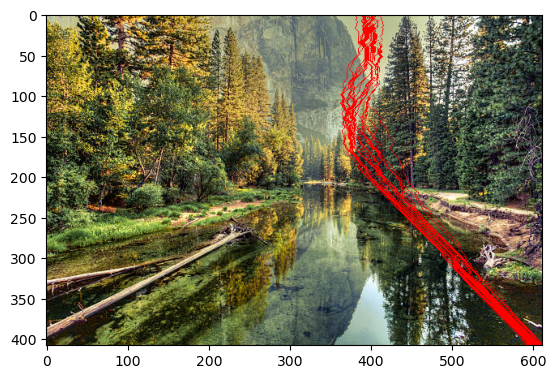

In [42]:
t = image
for i in range(t.size[1]):
    for k in range(K):
        t.putpixel((seams[i, k], i), (255, 0, 0))

plt.imshow(t)

In [43]:
for i in range(image.size[1]):
    seams[i].sort()
seams

array([[381, 388, 389, ..., 405, 406, 406],
       [381, 389, 390, ..., 405, 406, 408],
       [382, 389, 390, ..., 405, 406, 410],
       ...,
       [590, 592, 593, ..., 608, 609, 610],
       [591, 592, 593, ..., 608, 609, 610],
       [592, 593, 594, ..., 609, 610, 611]])

<Figure size 640x480 with 0 Axes>

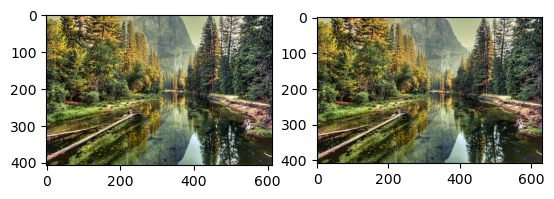

In [44]:
current_height = t.size[1]
current_width = t.size[0]
new_image = np.zeros([current_height, current_width + K, 3]).astype(int)
image = np.array(Image.open('assets/nature2.jpg')).astype(int)

for i in range(current_height):
    # idemo od 0 do seams[i, 0], pa do seams[i, 1]...
    for j in range(seams[i, 0] + 1):
        new_image[i, j] = image[i, j]
    if seams[i, 0] == 0:
        new_image[i, seams[i, 0] + 1] = image[i, seams[i, 0]] / 2
    else:
        new_image[i, seams[i, 0] + 1] = (image[i, seams[i, 0] - 1] + image[i, seams[i, 0] + 1]) / 2
    
    for k in range(K - 1):
        for j in range(seams[i, k] + k + 2, seams[i, k + 1] + k + 2):
            new_image[i, j] = image[i, j - k - 1]
            
        if seams[i, k + 1] == current_width - 1:
            new_image[i, seams[i, k + 1] + k + 2] = image[i, current_width - 1] / 2
        else:
            new_image[i, seams[i, k + 1] + k + 2] = (image[i, seams[i, k + 1] - 1] + image[i, seams[i, k + 1] + 1]) / 2
        
    for j in range(seams[i, K - 1] + K + 1, current_width + K):
        new_image[i, j] = image[i, j - K - 2]

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)